# XGBoost Model for Heart Disease Prediction
This notebook builds and evaluates an XGBoost classifier on the heart disease dataset. It follows the same structure as the Random Forest notebook, with clear code, visualizations, and markdown explanations.

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['teal', 'crimson'])
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Load data
data = pd.read_csv('../data/heart_featured.csv')
cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope', 'LawChol', 'LawOldpeak']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'

## Data Splitting and Preprocessing
XGBoost requires all features to be numeric. We'll use one-hot encoding for categoricals and standard scaling for numericals.

In [3]:
# Split data
y = data[target_col]
X = data.drop(columns=[target_col])
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

## XGBoost Model Training and Hyperparameter Tuning
We'll use grid search with stratified K-fold cross-validation to tune the XGBoost classifier.

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(xgb, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train_prep, y_train)

print(f'Best parameters: {gs.best_params_}')
print(f'Best CV accuracy: {gs.best_score_:.4f}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV accuracy: 0.8785
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV accuracy: 0.8785


Validation Accuracy: 0.8333333333333334
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.79      0.81        62
           1       0.84      0.87      0.85        76

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138

Confusion Matrix: [[49 13]
 [10 66]]


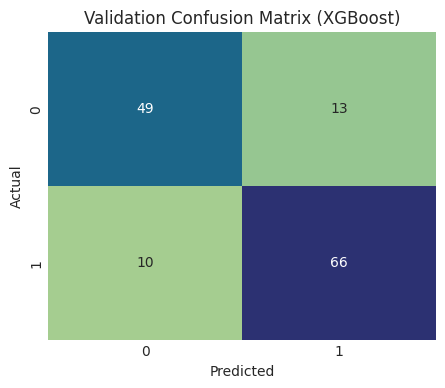

In [8]:
# Validation set evaluation
val_preds = gs.predict(X_val_prep)
print('Validation Accuracy:', accuracy_score(y_val, val_preds))
print('Classification Report:', classification_report(y_val, val_preds))
print('Confusion Matrix:', confusion_matrix(y_val, val_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix (XGBoost)')
plt.show()

Test Accuracy: 0.8913043478260869
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.90      0.88        62
           1       0.92      0.88      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138

Confusion Matrix: [[56  6]
 [ 9 67]]


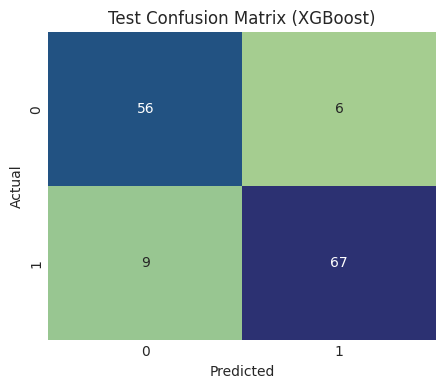

In [9]:
# Test set evaluation for XGBoost
test_preds = gs.predict(X_test_prep)
print('Test Accuracy:', accuracy_score(y_test, test_preds))
print('Classification Report:', classification_report(y_test, test_preds))
print('Confusion Matrix:', confusion_matrix(y_test, test_preds))

# Visualize confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix (XGBoost)')
plt.show()

In [10]:
# Save XGBoost model performance and feature importances to CSV
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
perf_rows = []
for split, X_, y_, preds in [
    ('validation', X_val_prep, y_val, val_preds),
    ('test', X_test_prep, y_test, test_preds),
    ]:
    perf_rows.append({
        'model': 'XGBoost',
        'split': split,
        'accuracy': accuracy_score(y_, preds),
        'precision': precision_score(y_, preds),
        'recall': recall_score(y_, preds),
        'f1': f1_score(y_, preds)
    })
perf_df = pd.DataFrame(perf_rows)
perf_df.to_csv('../data/model_performance.csv', mode='a', header=False, index=False)

# Save top 25 feature importances
importances = gs.best_estimator_.feature_importances_
feature_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
dx = np.argsort(importances)[::-1]
fi_df = pd.DataFrame({
    'model': 'XGBoost',
    'feature': [feature_names[i] for i in dx[:25]],
    'importance': importances[dx[:25]]
})
fi_df.to_csv('../data/feature_importance.csv', mode='a', header=False, index=False)